## REFERÊNCIAS
IDEIA ORIGINAL:
Adam Rosembrock
pyimagesearch.com - https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/




## AGENDA
Dentro do tutorial de hoje, você aprenderá como:

### Abrir uma base de imagens de raio-X (open data) de pacientes com resultado POSITIVO para COVID-19 e imagens de pacientes com resultado NEGATIVO.
### Dividir o dataset de imagens em conjunto de teste e conjunto de treino
### Aplicar a técnica de aumento de dados (Data Augmentation)
### Aplicar a técnica de transferência de inteligência entre redes neurais (Transfer Learning)
### Treinar uma Rede Neural Convolucional com o Tensorflow/Keras para detectar automaticamente o COVID-19 em imagens de raios-X
### Avaliar os resultados sob uma perspectiva educacional

## Imagens de Codiv


## Imagens Saudaveis



### bibliotecas

In [1]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import datetime as dt


from imutils import paths
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import pandas as pd
import uuid
import sys
import cv2
import os
# import inspect

import warnings
warnings.filterwarnings('ignore')

warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## carregando os dados 


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [87]:
diretorio_raiz=""
diretorio_dataset =""
diretorio_imagens_covid =""
diretorio_pneumonia_normal =""
diretorio_pneumonia_pneumonia =""
diretorio_imagens_notebook =""
diretorio_save_imagens_models =""
diretorio_imagens_validacao =""


In [88]:
def getDiretorio(tipo):
    retorno = ""
    if(tipo =="MaquinaLocal"):
        retorno = r'D:/Repos/AprendendoPython/Pos_Graduacao_BigData/TCC/Projeto'
    
    if(tipo =="GoogleDrive"):
       retorno=r'/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto'
       
    
    return retorno

In [89]:
# -- GoogleDrive
# --MaquinaLocal



diretorio_raiz = getDiretorio("GoogleDrive")
diretorio_dataset =r"{0}/{1}".format(diretorio_raiz,'dataset')
diretorio_imagem_covid =r"{0}/{1}".format(diretorio_dataset,'covid')
diretorio_pneumonia_normal =r"{0}/{1}".format(diretorio_dataset,'normal')
diretorio_imagens_validacao =r"{0}/{1}".format(diretorio_dataset,'validacao')
diretorio_imagens_notebook =r"{0}/{1}".format(diretorio_raiz,'Imagens_notebook')
diretorio_save_models =r"{0}/{1}".format(diretorio_raiz,'models')
diretorio_save_model_imagens =r"{0}/{1}".format(diretorio_save_models,'imagens')
print(diretorio_raiz)
print(diretorio_dataset)
print(diretorio_imagem_covid)
print(diretorio_pneumonia_normal)
print(diretorio_imagens_notebook)
print(diretorio_save_models)
print(diretorio_save_model_imagens)
print(diretorio_imagens_validacao)



/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto
/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/dataset
/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/dataset/covid
/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/dataset/normal
/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/Imagens_notebook
/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/models
/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/models/imagens
/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/dataset/validacao


In [90]:
class ConfiguracoesRedeNeuralCovid(object):
    def __init__(self):
        self.NomeModelo=""
        self.TamanhoModelo=""
        self.EPOCHS=""
        self.INIT_LR=""
        self.BS=""
        self.IMAGE_SIZE=""
        self.Descricao=""
        self.DataCriacao=""
        self.TotalImagens=""
        self.QtdImgCovid=""
        self.QtdImgNormal =""
        self.QtdImgTrainX=""
        self.QtdImgTestX=""
        self.QtdImgTrainY=""
        self.QtdImgTestY=""
        self.Rotation_range=""
        self.Fill_mode=""
        self.Test_size=""
        self.TipoCNN=""
        self.Versao =""
        self.Acuracia = ""
        self.Sensitividade =""
        self.Especificidade =""

    def to_dict(self):
        self.NomeModelo = self.get_ModelName()
        return {
            'NomeModelo' :self.NomeModelo,
            'TamanhoModelo':self.TamanhoModelo,
            'EPOCHS' :self.EPOCHS,
            'INIT_LR' :self.INIT_LR,
            'BS' : self.BS,
            'IMAGE_SIZE' :self.IMAGE_SIZE,
            'Descricao' :self.Descricao,
            'DataCriacao' :self.DataCriacao,
            'TotalImagens' :self.TotalImagens,
            'QtdImgCovid' :self.QtdImgCovid,
            'QtdImgNormal' :self.QtdImgNormal,
            'QtdImgTrainX' :self.QtdImgTrainX,
            'QtdImgTestX' :self.QtdImgTestX,
            'QtdImgTrainY' :self.QtdImgTrainY,
            'QtdImgTestY' :self.QtdImgTestY,
            'Rotation_range' :self.Rotation_range,
            'Fill_mode' :self.Fill_mode,
            'Test_size' :self.Test_size,
            "TipoCNN" :self.TipoCNN,
            "Versao" :self.Versao,
            "Acuracia" :self.Acuracia,
            "Sensitividade" :self.Sensitividade,
            "Especificidade" :self.Especificidade,

        }
    def get_ModelName(self):
      self.NomeModelo = "Model_{0}_{1}_EPOCHS_{2}_BS_{3}_ACC".format(self.TipoCNN, self.EPOCHS,self.BS,self.Acuracia) 
      return self.NomeModelo

    def get_propriedades(self):
      return [i for i in self.__dict__.keys() if i[:1] != '_']

    # Métodos são funções, que recebem como parâmetro atributos do objeto criado    
    def getInformacoes(self):
        print('Modelo {0}|{1} criado em {2} |com {3} EPOCHS|{4} IMG_COVID| {5} IMGPNEU|{6} IMGNORMAL'.
        format(self.IdModelo,self.NomeModelo,str(self.DataCriacao),self.EPOCHS,self.QtdImgCovid,self.QuantidadeImagensPneumonia,self.QtdImgNormal))

In [91]:
def ceildiv(a, b):
    return -(-a // b)

def plots_imagens_in_grid(imagens, figsize=(40,20), rows=5, take =10,  titles=None, maintitle=None,fromFile =True):
    
    tamanho = len(imagens[0:take])
    rows = take // 5
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=16)
    for i in range(tamanho):
        sp = f.add_subplot(rows, ceildiv(tamanho, rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        if(fromFile):
          img = plt.imread(imagens[i])
          plt.imshow(img)
        else:
          img = imagens[i]
          plt.imshow(img)

def get_configuracaoNetWorks(TipoCNN,EPOCHS,IMAGE_SIZE,BS,Rotation_range):
  config = ConfiguracoesRedeNeuralCovid()
  config.DataCriacao = dt.datetime.now()
  config.IMAGE_SIZE = IMAGE_SIZE
  config.INIT_LR = 1e-3
  config.EPOCHS = EPOCHS
  config.BS = BS
  config.Rotation_range=Rotation_range
  config.Fill_mode= str("nearest")
  config.Test_size=0.30
  config.TipoCNN =TipoCNN
  config.Versao ="V2"

  return config


def load_image(full_name,IMAGE_SIZE):
    # load image from file
    image = cv2.imread(full_name)

    if(image is None):
      return None
      
    # convert to RGB, if needed
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,IMAGE_SIZE)
    # convert to array
    return image

def get_imagens_from_diretory(diretorio):
  return list(paths.list_images(diretorio))

In [95]:
# config_VGG16 = get_configuracaoNetWorks("VGG16",EPOCHS= 50, IMAGE_SIZE=(224,224), BS= 8, Rotation_range= 15)
# config_Xception = get_configuracaoNetWorks("Xception",EPOCHS= 50, IMAGE_SIZE=(224,224), BS= 8, Rotation_range= 15)
# config_ResNet101 = get_configuracaoNetWorks("ResNet101",EPOCHS= 50, IMAGE_SIZE=(224,224), BS= 8, Rotation_range= 15)
config_VGG19 = get_configuracaoNetWorks("VGG19",EPOCHS= 100, IMAGE_SIZE=(150,150), BS= 32, Rotation_range= 15)

In [96]:
imagens_covid = get_imagens_from_diretory(diretorio_imagem_covid)

imagens_normal = get_imagens_from_diretory(diretorio_pneumonia_normal)

imagens_validacao_covid = get_imagens_from_diretory("{0}/{1}".format(diretorio_imagens_validacao,"covid"))
imagens_validacao_normal = get_imagens_from_diretory("{0}/{1}".format(diretorio_imagens_validacao,"normal"))


print("Imagens  Normal {0}".format(len(imagens_normal)))

print("Imagens  Covid {0}".format(len(imagens_covid)))

print(len(imagens_validacao_normal))
print(len(imagens_validacao_covid))



Imagens  Normal 671
Imagens  Covid 669
50
50


In [33]:
labels =[]
lista_imagens_erro = []
lista_imagens_com_Covid = []
lista_imagens_normal = []
lista_imagens_validacao_normal = []
lista_imagens_validacao_covid = []
lista_tuplas_imagens =[]

In [34]:
inicio = dt.datetime.now()

## imagens com Covid
IMAGE_SIZE = config_VGG19.IMAGE_SIZE

lista_imagens_com_Covid = []
for item in imagens_covid:
    image =  load_image(item,IMAGE_SIZE)
    prognostico = item.split(os.path.sep)[-2]
    prognostico = str(prognostico).lower()
    if(image is None):
        lista_imagens_erro.append(item)
    else:
        lista_tuplas_imagens.append((prognostico,image))
        lista_imagens_com_Covid.append(item)
  
## imagens Normais
lista_imagens_normal = []
for item in imagens_normal:
    image =  load_image(item,IMAGE_SIZE)
    prognostico = item.split(os.path.sep)[-2]
    prognostico = str(prognostico).lower()
    if(image is None):
        lista_imagens_erro.append(item)
    else:
        lista_tuplas_imagens.append((prognostico,image))
        lista_imagens_normal.append(item)


## imagens de Validação
lista_imagens_validacao_normal = []

for item in imagens_validacao_normal:
    image =  load_image(item,IMAGE_SIZE)
    prognostico = item.split(os.path.sep)[-2]
    prognostico = str(prognostico).lower()
    if(image is None):
        lista_imagens_erro.append(item)
    else:
        lista_imagens_validacao_normal.append(item)

lista_imagens_validacao_covid =[]

for item in imagens_validacao_covid:
    image =  load_image(item,IMAGE_SIZE)
    prognostico = item.split(os.path.sep)[-2]
    prognostico = str(prognostico).lower()
    if(image is None):
        lista_imagens_erro.append(item)
    else:
      lista_imagens_validacao_covid.append(item)
      


## recupera as imagens para validação posterior
tupla_imagens_validacao =[]

for item in imagens_validacao_covid:
    image =  load_image(item,IMAGE_SIZE)
    prognostico = item.split(os.path.sep)[-2]
    prognostico = str(prognostico).lower()
    if(image is not None):
        tupla_imagens_validacao.append((prognostico,image))
    

for item in imagens_validacao_normal:
    image =  load_image(item,IMAGE_SIZE)
    prognostico = item.split(os.path.sep)[-2]
    prognostico = str(prognostico).lower()
    if(image is not None):
        tupla_imagens_validacao.append((prognostico,image))


duracao = dt.datetime.now()-inicio 

print('A duração do processamento foi de', str(duracao)[:str(duracao).find('.')]) 


A duração do processamento foi de 0:07:22


In [97]:
config_VGG19.QtdImgCovid =len(lista_imagens_com_Covid)
config_VGG19.QtdImgNormal =len(lista_imagens_normal)
config_VGG19.TotalImagens = len(lista_tuplas_imagens)

print(config_VGG19.QtdImgCovid)
print(config_VGG19.QtdImgNormal)
print(config_VGG19.TotalImagens)

669
671
1340


Tratando classes - Labels

In [37]:
def get_labels(tupla, categorical=True):
  lb = LabelBinarizer()
  itens = [item[0] for item in tupla]
  itens = np.array(itens)
  itens = lb.fit_transform(itens)

  if(categorical):
    itens = to_categorical(itens)
  
  return itens,lb.classes_


def get_imagens(tupla):

  lista =[item[1] for item in tupla]

  lista = np.array(lista) / 255.0

  return lista
  

 

In [38]:
labels, classes = get_labels(lista_tuplas_imagens)

lista_imagens =get_imagens(lista_tuplas_imagens)



labels_ValidacaoPosterior = get_labels(tupla_imagens_validacao)[0]

lista_imagens_validacao_posteiror =get_imagens(tupla_imagens_validacao)


print(labels.shape)
print(labels_ValidacaoPosterior.shape)
print(lista_imagens.shape)

print(lista_imagens_validacao_posteiror.shape)

(1340, 2)
(100, 2)
(1340, 150, 150, 3)
(100, 150, 150, 3)


In [40]:
labels[660:675]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
imagens[0]

array([[[0.47843137, 0.47843137, 0.47843137],
        [0.29019608, 0.29019608, 0.29019608],
        [0.29803922, 0.29803922, 0.29803922],
        ...,
        [0.29411765, 0.29411765, 0.29411765],
        [0.29019608, 0.29019608, 0.29019608],
        [0.52941176, 0.52941176, 0.52941176]],

       [[0.25490196, 0.25490196, 0.25490196],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.34509804, 0.34509804, 0.34509804]],

       [[0.2627451 , 0.2627451 , 0.2627451 ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.        , 0.        , 0.        ],
        [0.35686275, 0.35686275, 0.35686275]],

       ...,

       [[0.35686275, 0.35686275, 0.35686275],
        [0.14509804, 0.14509804, 0.14509804],
        [0.20392157, 0

Definindo hyperparametros

In [39]:
batch_size   = 32 # processar de 32 em 32
input_shape  = (150, 150, 3)  #tamanho da matriz de entrada
random_state = 42 # simular os mesmos resultados
alpha        = 1e-5
epoch        = 100

## CALLBACKS

Callback são classes que auxiliam o treinamento do modelo usando o Keras. As classes que usaremos são:

### ModelCheckpoint
###  ReduceLROnPlateau
###  EarlyStopping

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

### ModelCheckpoint
### ModelCheckpoint nos ajudará a salvar o modelo para cada época, para que possamos treinar 
nosso modelo e não nos preocuparmos com 
### possíveis problemas que possam acontecer, como travamento da máquina.

### filepath: onde será salvo o modelo
### monitor: métrica a ser monitorada
###  verbose: (1) mostra na barra de progresso (0) não
### save_best_only: Salvar somente o melhor modelo
###  mode: como vamos monitorar o 'val_acc' o valor aqui vai ser 'max'. Queremos a máxima acurácia.

In [41]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### ReduceLROnPlateau Nos auxiliara a reduzir a taxa de aprendizado pelo fator (factor) caso não ocorra a mudança no loss.

### monitor: métrica a ser monitorada
###factor: fator de redução caso estejamos em um plator
### min_delta: valor mínimo da perda
### patience: só altere pelo fator após se repitir por 'patience' vezes.
### verbose: (1) mostra na barra de progresso (0) não

In [42]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

## Array de Callbacks

In [43]:

callbacks = [checkpoint, lr_reduce]

In [47]:
type(labels)

numpy.ndarray

## Particionando dataset em teste e treino

In [44]:
(trainX, testX, trainY, testY) = train_test_split(lista_imagens, labels, test_size=0.20, stratify=labels, random_state=random_state)

In [45]:

config_VGG19.QtdImgTestX = len(testX)
config_VGG19.QtdImgTestY = len(testY)
config_VGG19.QtdImgTrainX = len(trainX)
config_VGG19.QtdImgTrainY = len(trainY)


print("\n")
print("quantidade registros em  trainX {0}".format(config_VGG19.QtdImgTrainX))
print("quantidade registros em  testX {0}".format(config_VGG19.QtdImgTestX))
print("quantidade registros em  trainY {0}".format(config_VGG19.QtdImgTrainY))
print("quantidade registros em  testY {0}".format(config_VGG19.QtdImgTestY))



quantidade registros em  trainX 1072
quantidade registros em  testX 268
quantidade registros em  trainY 1072
quantidade registros em  testY 268


## Usando a tecnica de DATA AUGMENTATION

## nesse ponto aqui , temos que intender um pouco da anatomia do pulmão , pois não podemos flipar a imagem(inveter) , 
por que o posicionamento do pulmão faz diferença pois  o pulmão direito e mais acometido por doenças virais ou bacterianas 
a traqueia da direita e mais reta do que a esquerda.

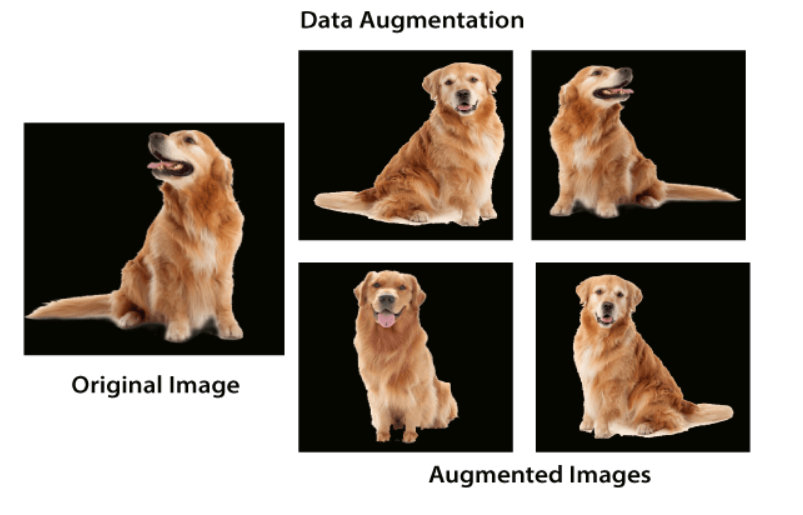

In [ ]:
from IPython.display import Image
Image('D:\Repos\AprendendoPython\Pos_Graduacao_BigData\TCC\Projeto\Imagens_notebook\Data_Aumentation.png')

## No conjuto ode dados de treinamento vamos gerar novas imagens  fazendo uma rotação de 20% e um zoom de 20 %

In [46]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2)

train_datagen.fit(trainX)


## depois vamos pegar essas imagens geradas e vincular a nossa variavel target (trainY)

In [47]:

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

TRANSFER LEARNING

## existe na internet um desafio chamado imagenet , com quase 12 milhoes de imagens
## e exxe desafio vai criando ao passar do tempos redes uma melhor que a outra 
## assim agente quer aproveitar essa super rede que ja foi trainada e pegar parte dela para usar no nosso problema

weights='imagenet'  vamos usar os pesos do treinamento ja feito pela  imagenet
include_top =False  não queremos o topo da rede , somente a parte das camadas covolucionais




In [48]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

80142336/80134624 [==============================] - 1s 0us/step


Total params: 20,024,384
Trainable params: 20,024,384


In [49]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## aqui vamos fazer a tecnica do ajuste fino 

As camadas inicias aprendem as carcteristicas muitos gerais  e a medida de descemos (deep) na rede 
as camadas tendem a apreder padroes mais especificos  para a tarefa quue está sendo treinada


Assim vamos manter as camadas inciais(congelar elas) e treinar novamente as camadas inferiores para que ela aprenda os nossos padrões







O ajuste fino ajuda em duas limitações

1) Nossa quantidade de dados para treinamento não e tão grande  porem podemos dar mais entendimento para a rede pre-treinada
poren não estamos utilizando o treinamento da rede toda

2) A parte que esta sendo treinada não esta sendo treinanda do zero     

In [50]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [61]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     


### GlobalAveragePooling2D  = e uma redução de resolução  vamos fazer pela media global , 
tambem podemos fazer pelo Maximo global ,pelo Minimo e pala media local

### BatchNormalization  = aumentar a estabilidade de uma rede neural , aplica uma normalização na saida do neuronio

### Flatten = faz o achatamento da matriz para um array 

### Uma camanda densa de 128 neuronios (vamos testar com 128 e 256 neuronios)

### Dropout vamos desligar 60 % dos neuronios para evitar que o modelo decore as regras de associacao (testar com 50 % tambem) 
assim vamos generalizar mais a rede (diminuir o overfit)


### ultima camada (camada densa de 2 saidas ( 0 ou 1 (com covid ou normal )))

### 


In [51]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

In [52]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

## treinamento da rede 


In [53]:
history = model.fit_generator(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size, # parte inteira da divisão
                              validation_data=(testX, testY),
                              validation_steps=len(testX) // batch_size,# parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.5699 - acc: 0.7240
Epoch 00001: val_acc improved from -inf to 0.50000, saving model to transferlearning_weights.hdf5
33/33 [==============================] - 16s 478ms/step - loss: 0.5699 - acc: 0.7240 - val_loss: 7.6685 - val_acc: 0.5000 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.3744 - acc: 0.8337
Epoch 00002: val_acc did not improve from 0.50000
33/33 [==============================] - 10s 302ms/step - loss: 0.3744 - acc: 0.8337 - val_loss: 7.6685 - val_acc: 0.5000 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.2592 - acc: 0.8856
Epoch 00003: val_acc did not improve from 0.50000
33/33 [==============================] - 10s 301ms/step - loss: 0.2592 - acc: 0.8856 - val_loss: 5.4814 - val_acc: 0.5000 - lr: 0.0010
Epoch 4/100
33/33 [==============================] 

Analisando os resultados

In [75]:
def print_classification_report(model,testX,testY,BS,classes,title):
  print("[INFO] {0} evaluating network...".format(title))
  
  predIdxs = get_predsIdxsX(model,testX,BS)

  print(classification_report(testY.argmax(axis=1), predIdxs,target_names=classes))


def get_predsIdxsX(model,testX, batch_size):

  predIdxs = model.predict(testX, batch_size)

  predIdxs = np.argmax(predIdxs, axis=1)

  return predIdxs



def plot_Hitorys(History,title_accuracy =None,title_loss = None):
  
  if(title_accuracy is None):
    title_accuracy ='model accuracy'
  
  if(title_loss is None):
    title_loss ='model loss'
  
  plt.plot(History.history['acc'])
  plt.plot(History.history['val_acc'])
  plt.title(title_accuracy)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(History.history['loss'])
  plt.plot(History.history['val_loss'])
  plt.title(title_loss)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


def plot_confusion_matrix(model_par,testX,testY,config):

  predIdxs = get_predsIdxsX(model_par,testX,config.BS)

  
  
  y_true = np.argmax(testY,axis = 1)

  cm = confusion_matrix(y_true, predIdxs)

  total = sum(sum(cm))

  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


  config.Acuracia ="{:.4f}".format(acc)
  config.Especificidade ="{:.4f}".format(specificity)
  config.Sensitividade ="{:.4f}".format(sensitivity)

  print("Acurácia: {:.4f}".format(acc))
  print("Sensitividade: {:.4f}".format(sensitivity))
  print("Especificidade: {:.4f}".format(specificity))


  from mlxtend.plotting import plot_confusion_matrix
  fig, ax = plot_confusion_matrix(conf_mat=cm ,figsize=(5, 5),show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                
                                )
  plt.show()



In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print_classification_report(model=model, testX=testX,testY=testY, BS= config_VGG19.BS, classes= classes, title= "VGG19")

[INFO] VGG19 evaluating network...
              precision    recall  f1-score   support

       covid       0.96      0.96      0.96       134
      normal       0.96      0.96      0.96       134

    accuracy                           0.96       268
   macro avg       0.96      0.96      0.96       268
weighted avg       0.96      0.96      0.96       268



Acurácia: 0.9590
Sensitividade: 0.9627
Especificidade: 0.9552


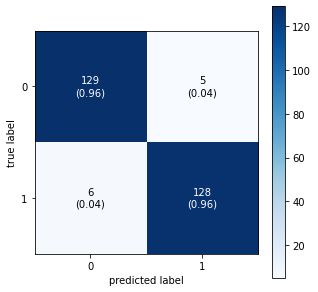

In [76]:
plot_confusion_matrix(model_par=model, testX= testX, testY=testY,config= config_VGG19)

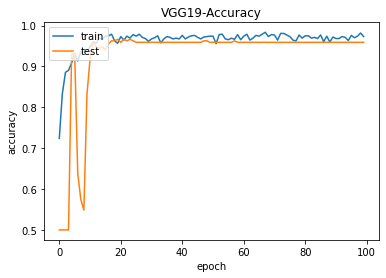

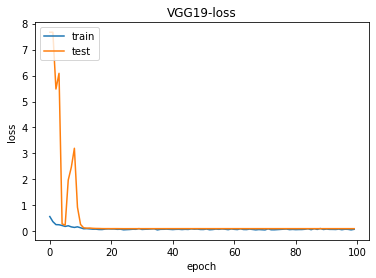

In [74]:
plot_Hitorys(history,'VGG19-Accuracy','VGG19-loss')

Gerando matriz de confusão

Também estamos obtendo 100% de sensibilidade e 92% de especificidade, o que implica que:

Sensibilidade, capacidade indentificar caso positivo de COVID-19 com o modelo é de 100%.
Especificidade, capacidade indentificar caso Não-Positivo de COVID-19 com o modelo é de 92,31%.
Como mostra nosso gráfico de histórico de treinamento, nossa rede não está adaptando demais, apesar de ter dados de treinamento limitado

In [102]:
model_save_VGG19 = "{0}/{1}.h5".format(diretorio_save_models,"{0}_{1}".format(config_VGG19.Versao,config_VGG19.NomeModelo))

print(model_save_VGG19)

model.save(model_save_VGG19)

/content/drive/My Drive/TCC Pos Graduação big data/TCC/Projeto/models/V2_Model_VGG19_100_EPOCHS_32_BS__ACC.h5


## Salvar as informaçoes dos modelos no Excel

In [105]:

df_versionModels = pd.DataFrame()
# df_versionModels.drop(df_versionModels.index, inplace=True)

# df_versaoVGG16 = pd.DataFrame(config_VGG16.to_dict())
# df_versaoXception = pd.DataFrame(config_Xception.to_dict())
df_versaoVGG19 = pd.DataFrame(config_VGG19.to_dict())

# df_versaoResNet101 = pd.DataFrame(config_ResNet101.to_dict())
# df_versionModels =pd.concat([df_versionModels, df_versaoVGG16.head(1)])
# df_versionModels =pd.concat([df_versionModels, df_versaoXception.head(1)])
df_versionModels =pd.concat([df_versionModels, df_versaoVGG19.head(1)])


df_versionModels

,NomeModelo,TamanhoModelo,EPOCHS,INIT_LR,BS,IMAGE_SIZE,Descricao,DataCriacao,TotalImagens,QtdImgCovid,QtdImgNormal,QtdImgTrainX,QtdImgTestX,QtdImgTrainY,QtdImgTestY,Rotation_range,Fill_mode,Test_size,TipoCNN,Versao,Acuracia,Sensitividade,Especificidade
0,Model_VGG19_100_EPOCHS_32_BS__ACC,,100,0.001,32,150,,2020-06-27 11:51:48.223119,1340,669,671,,,,,15,nearest,0.3,VGG19,V2,,,


In [106]:
import os

# os.listdir("{0}/{1}".format(diretorio_raiz,"Excel"))

full_save_excel = r"{0}/{1}/{2}.xlsx".format(diretorio_raiz,"Excel","Versões")


if (os.path.exists(full_save_excel)):
  da_versoes = pd.read_excel(full_save_excel)

  da_versoes = da_versoes.append(df_versionModels,ignore_index = True)

  da_versoes.to_excel(full_save_excel, index = False, header=True)

else:
  print('Arquivo Não Localizado')
  df_versionModels.to_excel(full_save_excel, index = False, header=True)

  da_versoes  = pd.read_excel(full_save_excel)

da_versoes




,NomeModelo,TamanhoModelo,EPOCHS,INIT_LR,BS,IMAGE_SIZE,Descricao,DataCriacao,TotalImagens,QtdImgCovid,QtdImgNormal,QtdImgTrainX,QtdImgTestX,QtdImgTrainY,QtdImgTestY,Rotation_range,Fill_mode,Test_size,TipoCNN,Versao,Acuracia,Sensitividade,Especificidade
0,Model_VGG16_30_EPOCHS_8_BS_0.8856_ACC,NaN,30,0.001,8,224,NaN,2020-06-25 20:26:34.712000,1340,669,671,938,402,938,402,15,nearest,0.3,VGG16,V1,0.8856,0.8657,0.9055
1,Model_Xception_30_EPOCHS_8_BS_0.8930_ACC,NaN,30,0.001,8,224,NaN,2020-06-25 20:26:34.712000,1340,669,671,938,402,938,402,15,nearest,0.3,Xception,V1,0.893,0.8706,0.9154
2,Model_VGG19_50_EPOCHS_8_BS_0.8234_ACC,NaN,50,0.001,8,224,NaN,2020-06-25 20:26:34.712000,1340,669,671,938,402,938,402,15,nearest,0.3,VGG19,V1,0.8234,0.8806,0.7662
3,Model_VGG16_40_EPOCHS_8_BS_0.8905_ACC,NaN,40,0.001,8,224,NaN,2020-06-26 11:07:15.277000,1340,669,671,938,402,938,402,15,nearest,0.3,VGG16,V1,0.8905,0.8856,0.8955
4,Model_Xception_40_EPOCHS_8_BS_0.8781_ACC,NaN,40,0.001,8,224,NaN,2020-06-26 11:07:15.277000,1340,669,671,938,402,938,402,15,nearest,0.3,Xception,V1,0.8781,0.7861,0.9701
5,Model_VGG19_50_EPOCHS_8_BS_0.8632_ACC,NaN,50,0.001,8,224,NaN,2020-06-26 11:07:15.277000,1340,669,671,938,402,938,402,15,nearest,0.3,VGG19,V1,0.8632,0.8706,0.8557
6,Model_VGG19_50_EPOCHS_8_BS_0.9590_ACC,NaN,50,0.001,8,150,NaN,2020-06-27 10:59:11.519000,1340,669,671,1072,268,1072,268,15,nearest,0.3,VGG19,V1,0.959,0.9627,0.9552
7,Model_VGG19_100_EPOCHS_32_BS__ACC,,100,0.001,32,150,,2020-06-27 11:51:48.223119,1340,669,671,,,,,15,nearest,0.3,VGG19,V2,,,


In [107]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
# new_VGG16Model = load_model(model_save_VGG16)

new_VGG19Model = load_model(model_save_VGG19)

# new_Xception = load_model(model_save_Xception)

# new_ResNet101 = load_model(model_save_ResNet101)



## predição das 50 imagens não vistas

In [111]:
def load_image(var_imagem,size =None):

    if(size is None):
      size = (224, 224)

    image = cv2.imread(var_imagem)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    imagem_array = np.expand_dims(image, axis = 0)

    return imagem_array,image


def plot_predition(pred,image):
  categorias_predicao = ['covid', 'normal']
  
  predicao = categorias_predicao[np.argmax(pred)]

  plt.title(predicao)
    
  plt.imshow(image/255.)
  plt.savefig('Predition_plot.png')

def plot_imagens_predition(model,testX,testY,config, take=60):
  labels=['covid','normal']
  plt.figure(figsize =(40,40))
  
  predIdxs = get_predsIdxsX(model,testX,config.BS)

  for i in range(take):
      plt.subplot(10,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.title("{0}-{1}".format(i,labels[(np.argmax(testY[i], axis=0))]),fontsize=14)
      # plt.imshow(trainX.reshape(-1,224,224,3)[i])
      plt.imshow(testX.reshape(-1,150,150,3)[i])
      
      

      if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel(labels[predIdxs[i]],color='blue',fontsize=14)
      else:
        plt.xlabel(labels[predIdxs[i]],color='red',fontsize=14)
          
  plt.show()


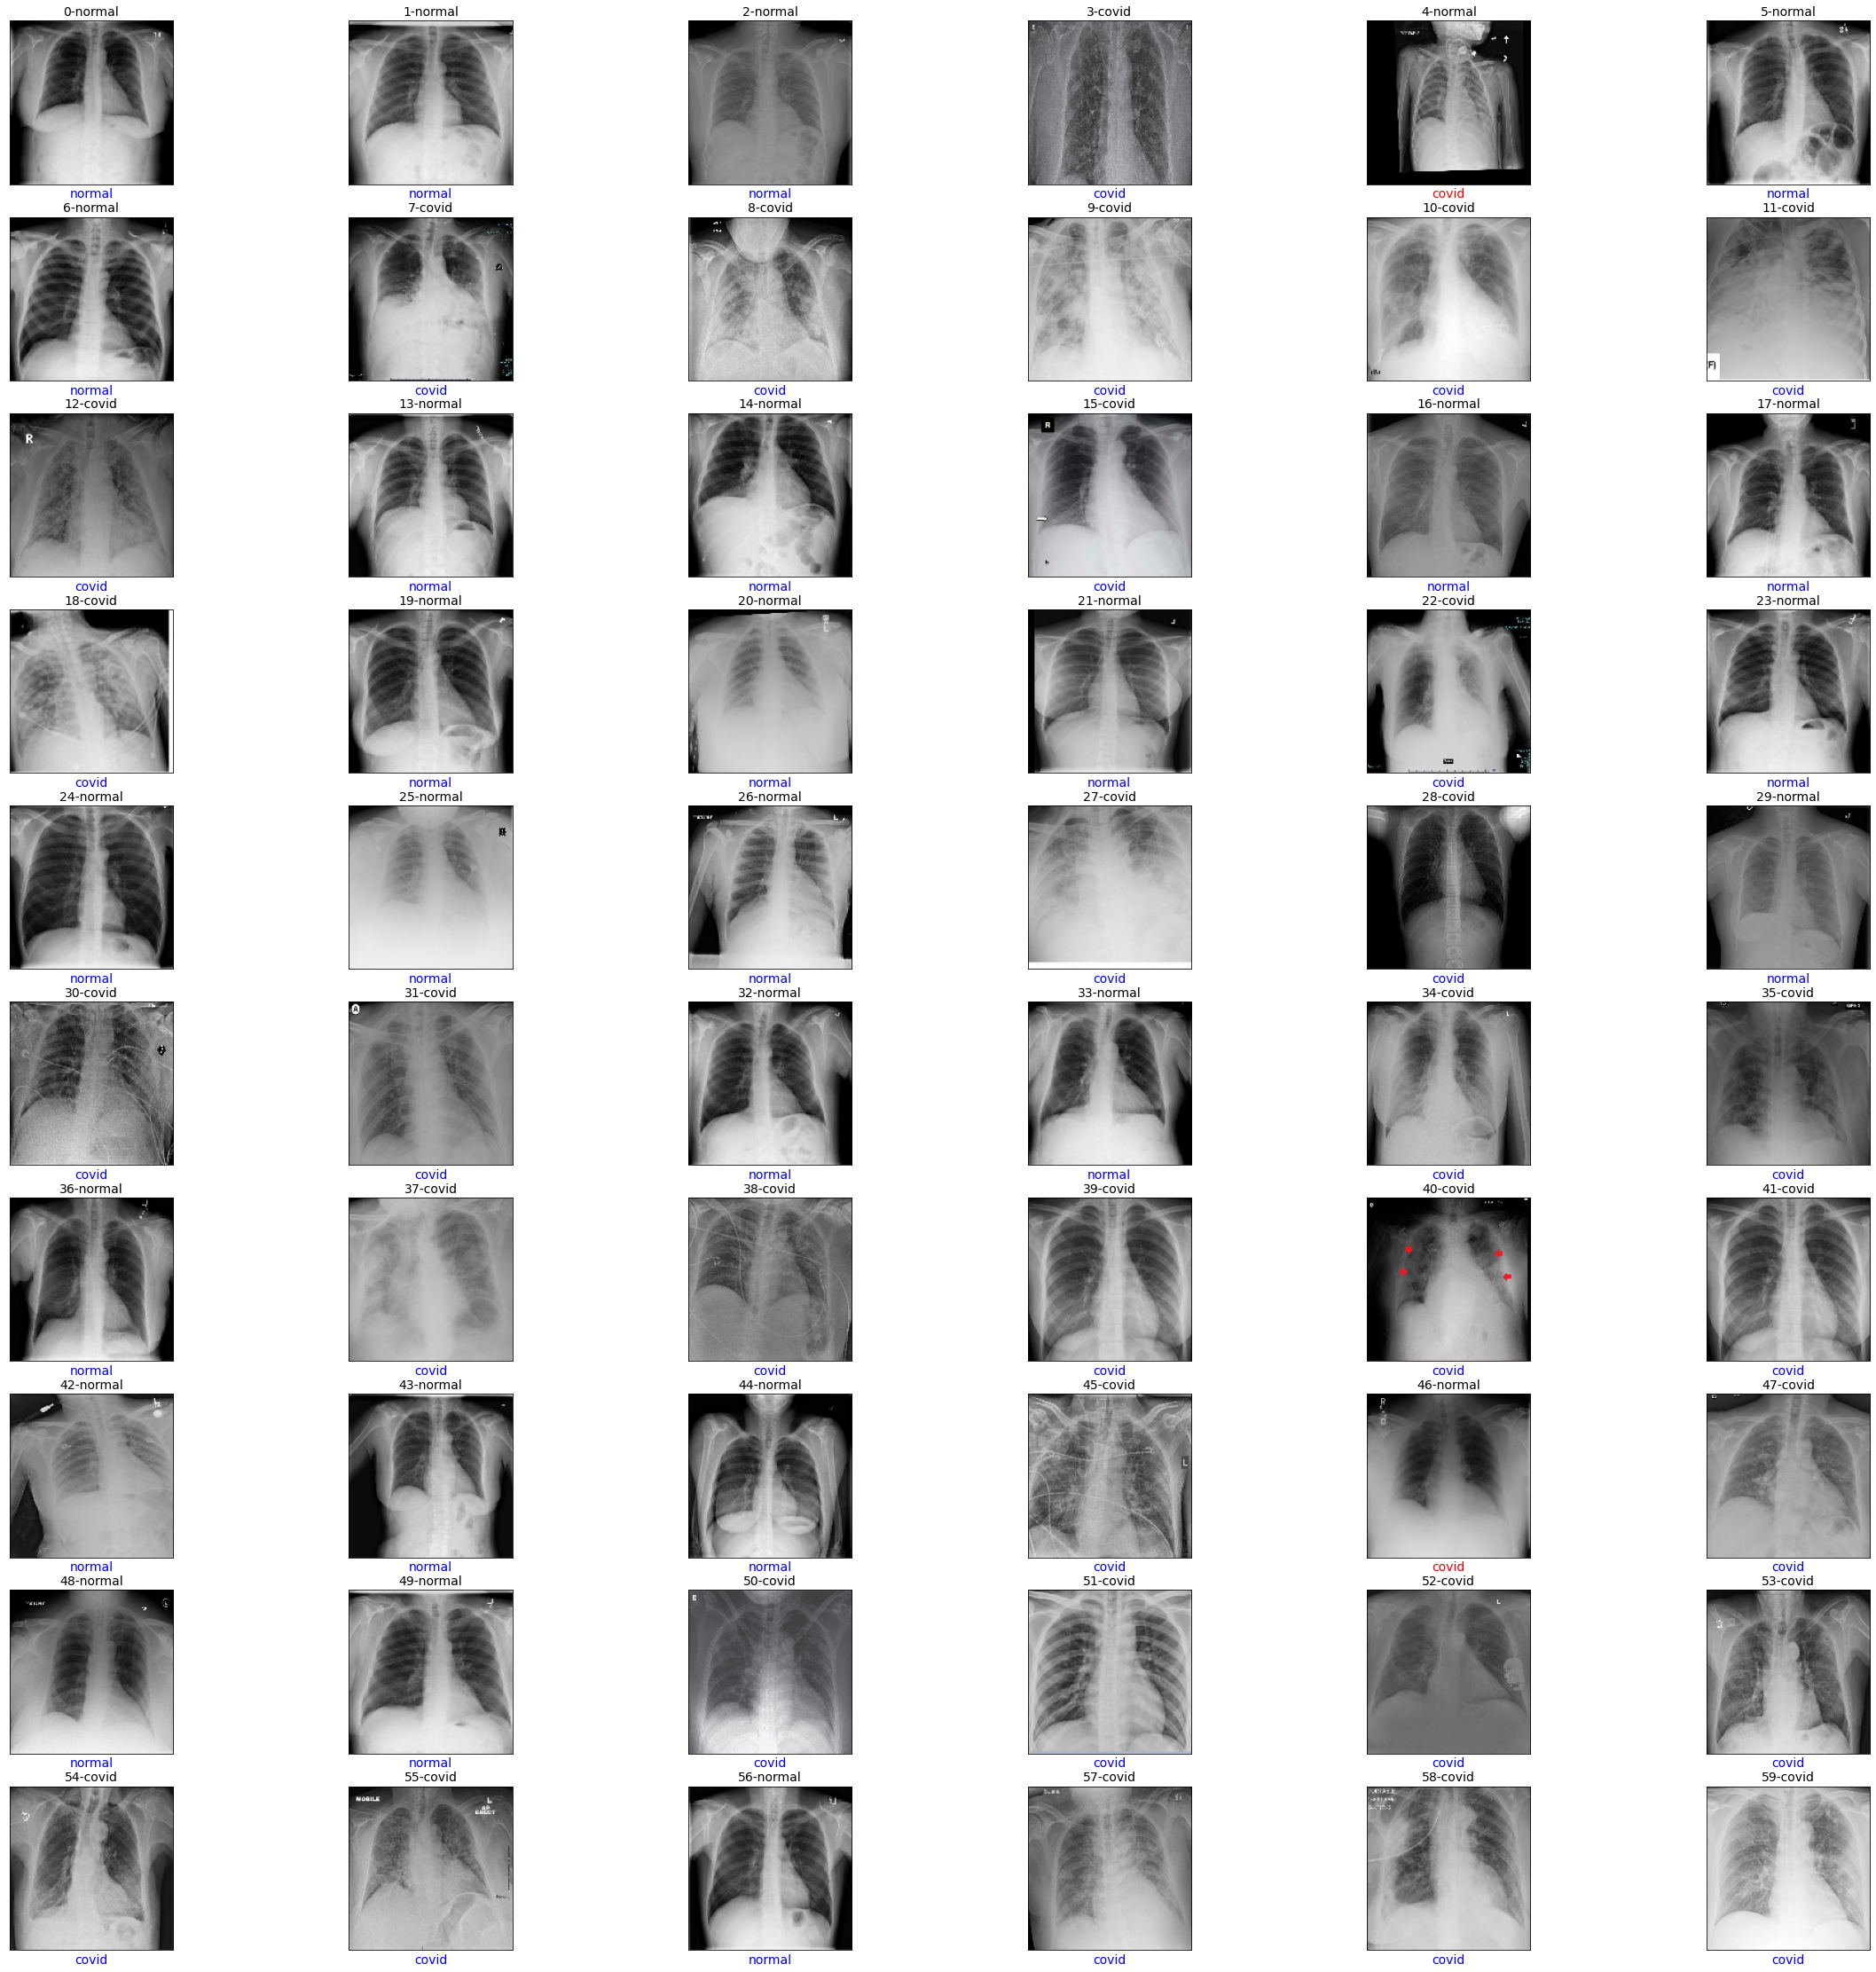

In [112]:
plot_imagens_predition(model=new_VGG19Model,testX=testX,testY=testY,config=config_VGG19)